# ROC, AUC

In [20]:
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

def draw_ROC_and_get_AUC(test_y, y_score, n_classes=2):

  test_y = np.eye(n_classes)[test_y]
  y_score = np.eye(n_classes)[y_score]

  # Plot linewidth.
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1)
  plt.plot(fpr["macro"], tpr["macro"],
          label='ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

  return roc_auc["macro"]

# 2개 클래스

## 데이터 준비

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!wget https://raw.githubusercontent.com/dhrim/DMC_2022/master/material/deep_learning/data/sonar.csv

--2022-07-01 08:16:14--  https://raw.githubusercontent.com/dhrim/DMC_2022/master/material/deep_learning/data/sonar.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87776 (86K) [text/plain]
Saving to: ‘sonar.csv’

sonar.csv           100%[===================>]  85.72K  --.-KB/s    in 0.02s   

2022-07-01 08:16:14 (5.16 MB/s) - ‘sonar.csv’ saved [87776/87776]



In [6]:
raw_data = pd.read_csv("sonar.csv")
data = raw_data.to_numpy()
np.random.shuffle(data)

x = data[:,:60]
y = data[:,60].astype(np.int16)

split_index = int(len(x)*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


## 학습

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                610       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


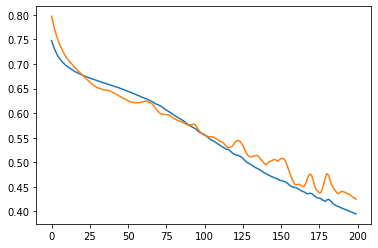

2/2 [==============================] - 0s 7ms/step - loss: 0.5021 - acc: 0.7381
loss= 0.5020686388015747
acc= 0.738095223903656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


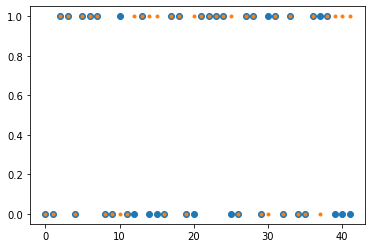

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC, Precision, Recall

model = keras.Sequential()
model.add(Dense(10, activation='relu', input_shape=(60,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

history = model.fit(train_x, train_y, epochs=200, verbose=0, batch_size=128, validation_split=0.1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)




y_ = model.predict(test_x)
predicted = (y_>0.5).astype(np.int16).squeeze()

plt.plot(test_y, "o")
plt.plot(predicted, ".")
plt.show()

## ROC 그리기, AUC 출력

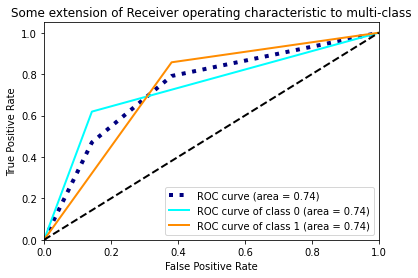

AUC  0.738095238095238


In [12]:
auc = draw_ROC_and_get_AUC(test_y, predicted, n_classes=2)
print("AUC ", auc)

## Confusion Matric

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predicted)
print(cm)

[[13  8]
 [ 3 18]]


In [15]:
print(classification_report(test_y, predicted, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.69      0.86      0.77        21

    accuracy                           0.74        42
   macro avg       0.75      0.74      0.73        42
weighted avg       0.75      0.74      0.73        42



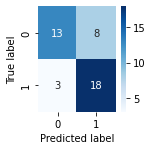

In [16]:
import seaborn as sns

figure = plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# n개 클래스

## 데이터 준비

In [17]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

train_x = raw_train_x/255
test_x = raw_test_x/255

train_y = raw_train_y
test_y = raw_test_y

11501568/11490434 [==============================] - 0s 0us/step


## 학습

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape
from tensorflow.keras.metrics import *

import time


model = keras.Sequential()
model.add(Input((28,28)))
model.add(Reshape((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


hist = model.fit(train_x, train_y, epochs=5, verbose=1, validation_split=0.1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)             

## ROC 그리기, AUC 출력

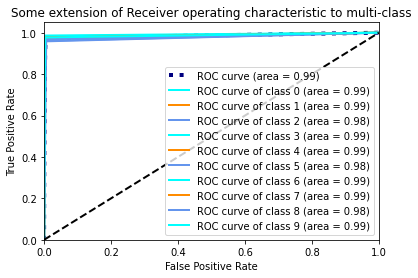

AUC  0.985725678951989


In [21]:
auc = draw_ROC_and_get_AUC(test_y, predicted, n_classes=10)
print("AUC ", auc)

## Confusion Matric

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predicted)
print(cm)

[[ 963    0    1    0    1    1    6    3    3    2]
 [   0 1111    1    1    1    1    4    7    9    0]
 [   1    2  989    3    3    0    0   11   23    0]
 [   0    1   12  984    0    1    0    3    6    3]
 [   0    1    2    0  962    0    3    0    2   12]
 [   2    0    0   10    1  857   13    1    6    2]
 [   3    1    0    0    5    1  945    0    3    0]
 [   0    0   15    1    4    0    0 1004    1    3]
 [   6    1    4    2    2    0    5    3  943    8]
 [   5    3    0    3    3    0    0    4    5  986]]


In [23]:
print(classification_report(test_y, predicted, target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       1.00      0.96      0.98       892
           6       0.97      0.99      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.94      0.97      0.95       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



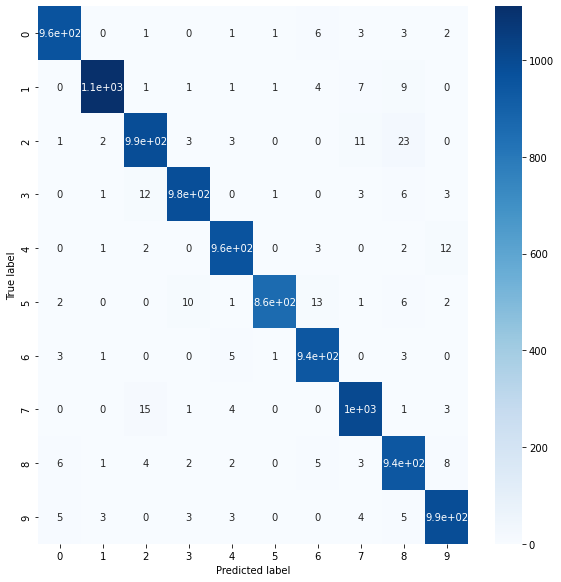

In [24]:
import seaborn as sns

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()